# Projekt: MotorBoat pricing

Celem projtku jest jak najlepsze przewidzenie cen łodzi na podstawie zbioru danych: https://www.kaggle.com/datasets/artemkorottchenko/large-boatyacht-pricing-dataset

![title](jetski.png)

In [1]:
#wszystkie biblioteki uzywane w projekcie

import numpy as np
import pandas as pd
import seaborn as sb
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
import tensorflow as tf
from tensorflow import keras

Wczytanie danych

In [2]:
PATH = os.path.join("datasets", "archive1")
csv_path = os.path.join(PATH, "boat_dataset.csv")
data = pd.read_csv(csv_path, encoding="utf8", encoding_errors='ignore', on_bad_lines='skip')

In [3]:
data

,Price,Category,Boat Type,Manufacturer,Model,Boat name,Type,Year Built,Condition,Length,...,Fuel Type,Engine Hours,Max Speed,Cruising Speed,Location,Advertisement Date,Number of views last 7 days,Comments,Additional Comments,Equipment
0,"CHF 3.337,-",Power Boats,Motor Yacht,Rigiflex power boats,CAP 400,NaN,new boat from stock,2017.0,as new,4.00 m,...,NaN,NaN,NaN,NaN,Switzerland » Lake Geneva » Vésenaz,NaN,226,NaN,Possibility to arrange it with a complete luxu...,NaN
1,"EUR 3.490,-",Power Boats,Center console boat,Terhi power boats,400 C,NaN,new boat from stock,2020.0,new,4.00 m,...,NaN,NaN,NaN,NaN,Germany » Bönningstedt,NaN,75,"In den Farben weiß oder grün lieferbar.,,2 abs...",NaN,NaN
2,"CHF 3.770,-",Power Boats,Sport Boat,Marine power boats,370 S - Aluboot,NaN,new boat from stock,NaN,NaN,3.69 m,...,NaN,NaN,NaN,NaN,Switzerland » Lake of Zurich » Stäfa ZH,NaN,124,NaN,The lightweight and sleek rowing boat for 4 pe...,NaN
3,"DKK 25.900,-",Power Boats,Sport Boat,Pioner power boats,10 Classic Special Edition,NaN,new boat from stock,2020.0,NaN,3.00 m,...,NaN,NaN,NaN,NaN,Denmark » Svendborg,NaN,64,"MORSOM OG LETKØRT KVALITETSBÅD!,Nye Pioner 10 ...",NaN,NaN
4,"SEK 35.000,-",Power Boats,Classic,NaN,Gullholmensnipa 21,NaN,Used boat,1974.0,good,6.30 m,...,NaN,500 h,NaN,NaN,Nordsee » Västra Frölunda,04.07.2020,131,NaN,NaN,"Anchor,Battery,Bilge Pump,Bilge pump,Cockpit C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,"EUR 4.516,-",Power Boats,Sport Boat,NaN,FOX BOATS 420C EC,NaN,new boat from stock,NaN,NaN,4.17 m,...,NaN,NaN,NaN,NaN,Germany » Hamburg » HAMBURG,NaN,94,"Länge: 4,17m | Breite: 1,67m | max. Motorisier...",NaN,NaN
10340,"EUR 4.499,-",Power Boats,Sport Boat,BlueCraft power boats,BlueSloep 140,NaN,"new boat from stock,Unleaded",2020.0,NaN,4.40 m,...,Unleaded,NaN,NaN,NaN,Germany » Nordrhein-Westfalen » Wesel,NaN,354,NaN,The BlueSloep 140 is the smallest boat in the ...,NaN
10341,"EUR 4.300,-",Power Boats,Pontoon Boat,Whaly power boats,450 New Classic,NaN,new boat from stock,2018.0,new,4.37 m,...,NaN,NaN,NaN,NaN,Italy » Dormelletto,NaN,266,"Caratteristiche tecniche,,Materiale: Polietile...",NaN,NaN
10342,"EUR 3.500,-",Power Boats,Sport Boat,Fletcher power boats,Bravo,NaN,"Used boat,Unleaded",1992.0,good,4.27 m,...,Unleaded,10 h,NaN,NaN,Hungary » Ebes,23.07.2020,NaN,Trailer comes with two new tyres and new wheel...,NaN,"Battery,Fire Extinguisher,Full Enclosure,Speed..."


Zestaw danych zawiera 38 kolumn. Nie wszystkie kolumny zawierają dane użyteczne podczas uczenia modelu zatem można się ich pozbyć.

In [4]:
data.columns

Index(['Price', 'Category', 'Boat Type', 'Manufacturer', 'Model', 'Boat name',
       'Type', 'Year Built', 'Condition', 'Length', 'Width', 'Depth',
       'Displacement', 'CE Design Category', 'Cert Number of People',
       'Number of Cabins', 'Number of beds', 'Hull Color', 'Number of Toilets',
       'Number of Bathrooms', 'Number of Showers', 'Material',
       'Fresh Water Cap', 'Holding Tank', 'Propulsion', 'Engine',
       'Engine Performance', 'Fuel Capacity', 'Fuel Type', 'Engine Hours',
       'Max Speed', 'Cruising Speed', 'Location', 'Advertisement Date',
       'Number of views last 7 days', 'Comments', 'Additional Comments',
       'Equipment'],
      dtype='object')

Poniżej znajduje sie mapa korelacji pomiędzy kolumnami numerycznymi.

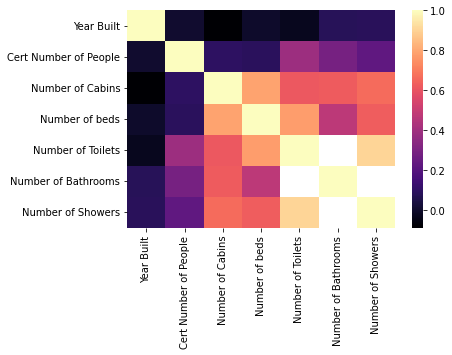

In [5]:
sb.heatmap(data.corr(), cmap = 'magma')

plt.show()

Zakładam, że przy nieco ponad 10 000 wierszach w zbiorze danych, kolumny zawierające mniej niż 1000 wartości "non-null" nie bedą zbyt użyteczne. Poniżej wypisane zostały kolumny z obliczonymi ilościami uzupełnionych wierszy.

Takimi kolumnami są:
- CE Design Category 
- Number of Bathrooms 
- Holding Tank (zbiornik sanitarny)
- Max Speed
- Cruising Speed
- Advertisement Date

CE Design Category zawiera informacje na jakich wodach można pływać daną łodzią - choć mogłoby to wpływać na cenę nie ma niestety możliwości by te dane uzupełnić. Podobnie w przypadku kolumn Max Speed i Cruising Speed.

Advertisement Date nie dostarcza żadnych informacji na temat ceny. 

W przypadku pozostałych kolumn informacje w nich zawarte mogą mieć duży wpływ na cenę zatem spróbuję je jakoś wykorzystać.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10344 entries, 0 to 10343
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        10344 non-null  object 
 1   Category                     10344 non-null  object 
 2   Boat Type                    10344 non-null  object 
 3   Manufacturer                 8954 non-null   object 
 4   Model                        10341 non-null  object 
 5   Boat name                    1313 non-null   object 
 6   Type                         10339 non-null  object 
 7   Year Built                   9777 non-null   float64
 8   Condition                    3375 non-null   object 
 9   Length                       10334 non-null  object 
 10  Width                        10281 non-null  object 
 11  Depth                        7234 non-null   object 
 12  Displacement                 5051 non-null   object 
 13  CE Design Catego

In [7]:
data = data.drop(["CE Design Category", "Max Speed", "Cruising Speed", "Advertisement Date"], axis = 1)

Można także zrezygnować z kolumny zawierającej dane na temat koloru kadłuba - łodzie w większości są koloru białego; dodatkowo nie wszystkie dane są w języku angielskim.

In [8]:
print(data["Hull Color"].loc[data["Hull Color"].notnull()][:15])
data = data.drop(["Hull Color"], axis = 1)

0            white
9      white white
15            grey
17       red weiss
18       grey grey
21           White
26           white
30     green green
32            grey
34     white white
39         red red
43    beige, braun
50           White
52       white ROT
54       blue blue
Name: Hull Color, dtype: object


Następnie usuwamy kolumny z komentarzami, ponieważ wydobycie z nich jakichkolwiek przydatnych informacji jest niemal niemożliwe.

In [9]:
data = data.drop(["Comments", "Additional Comments"], axis = 1)

Następnie sprawdzam czy dane dotyczące lokalizacji łodzi będą w jakikolwiek sposób przydatne.

In [10]:
data["Location"] = data["Location"].fillna('')
data["Location"] = data["Location"].map(lambda x: x.split(' ')[0].strip())

In [11]:
data["Location"].unique()

array(['Switzerland', 'Germany', 'Denmark', 'Nordsee', 'Italy', 'France',
       'United', 'Spain', 'Austria', 'Netherlands', 'Slovenia', 'Serbia',
       'Finland', 'Belgium', 'Slovak', 'Croatia', 'Portugal', 'Malta',
       'Sweden', 'Montenegro', 'Latvia', 'Rovinij', 'Steinwiesen',
       'Greece', 'Rolle', 'Poland', 'baden', 'Donau', 'Travemünde',
       'Lake', 'Turkey', 'Stralsund', 'Rostock', 'Split', 'lago',
       'België,', 'Niederrhein', 'Hungary', 'Brandenburg', 'Rügen',
       'Zevenbergen', 'Oder', 'st', 'Cyprus', 'Faoug', 'Beilngries',
       'Czech', 'Lithuania', 'Marina', 'Ukraine', 'French', 'Italien',
       'Zadar', '', 'Estonia', 'Virgin', 'Monaco', 'Russian', 'waren',
       'South', 'Egypt', 'Jersey', 'Australia', 'Bulgaria', 'Oman',
       'Taiwan', 'Åland', 'Philippines', 'Thailand', 'Luxembourg',
       'Venezuela', 'Neustadt', 'Ireland', 'Adria', 'Martinique',
       'Bahamas', 'Norway', 'Seychelles', 'Morocco', 'Gibraltar',
       'Lebanon', 'Ostsee', 'Mallo

Niestety z powodu zbyt wielu różnych informacji nie są potrzebne.

In [12]:
data = data.drop(["Location"], axis = 1)

Kolejno zajmuję się przetworzeniem danych dotyczących ceny - zależy mi na tym by były one wyrażone w tej samej walucie.

In [13]:
data["Price"].value_counts()

EUR 65.000,-       81
EUR 45.000,-       69
EUR 75.000,-       66
EUR 89.000,-       66
EUR 35.000,-       65
                   ..
EUR 1.285.000,-     1
EUR 1.280.500,-     1
EUR 1.270.000,-     1
£ 1.150.000,-       1
CHF 3.780,-         1
Name: Price, Length: 3283, dtype: int64

In [14]:
tmp = data["Price"].copy()
data.insert(1, "Currency", tmp)

In [15]:
data["Currency"] = data["Currency"].map(lambda x: x.split()[0].strip())

In [17]:
print(data["Currency"].unique())
print(data["Currency"].value_counts())

['CHF' 'EUR' 'DKK' 'SEK' '£' 'Price' 'USD']
EUR      8700
CHF      1036
£         306
DKK       183
Price      44
USD        39
SEK        36
Name: Currency, dtype: int64


Niektóre ceny zostały podane jako "do ustalenia" zatem należało pozbyć się tych wierszy.

In [18]:
opt = ["Price"]
print(data[data["Currency"].isin(opt)]["Price"][:10])

909     Price on request
2818    Price on request
3471    Price on request
3472    Price on request
3473    Price on request
3474    Price on request
3475    Price on request
3476    Price on request
3477    Price on request
3478    Price on request
Name: Price, dtype: object


In [19]:
data = data.where(data["Currency"] != "Price", other = None)
data = data.dropna(subset = ["Currency"])

In [21]:
data["Price"] = data["Price"].map(lambda x: x.split()[1].strip())
data["Price"] = data["Price"].map(lambda x: x.split(',')[0].strip())
data["Price"] = data["Price"].map(lambda x: ''.join(x.split('.')))

data["Price"] = pd.to_numeric(data["Price"])

#zaokraglone wartosci
exchange = {
    'CHF' : 1,
    'EUR' : 1,
    'DKK' : 0.15,
    'SEK' : 0.09,
    '£' : 1.15,
    'USD' : 1.05
}

data.loc[data["Currency"] == 'CHF', "Price"] *= exchange.get('CHF')
data.loc[data["Currency"] == 'DKK', "Price"] *= exchange.get('DKK')
data.loc[data["Currency"] == 'SEK', "Price"] *= exchange.get('SEK')
data.loc[data["Currency"] == '£', "Price"] *= exchange.get('£')
data.loc[data["Currency"] == 'USD', "Price"] *= exchange.get('USD')

In [22]:
data = data.dropna(subset = ["Price"]) #na wszelki wypadek pozbywam sie pustych wierszy

Następną kolumną do sprawdzenia jest Category - jednak zawiera ona tylko jedną wartość.

In [23]:
data["Category"].value_counts()

Power Boats    10300
Name: Category, dtype: int64

In [24]:
data = data.drop(["Category"], axis = 1)

Cena zależy przede wszystkim od rodzaju i wielkości łodzi, więc dane z kolumny Boat Type zostaną dokładnie przetworzone. Najpierw ograniczam je do tylko jednego z podanych typów (jeśli jest ich więcej) i dalej w kodzie będą zamieniane na dane numeryczne.

In [25]:
data["Boat Type"].value_counts()

Motor Yacht                             2829
Sport Boat                              1457
Flybridge                               1227
Trawler                                  698
Pilothouse                               634
                                        ... 
Cabin Boat,Motor Yacht,Offshore Boat       1
Classic,Mega Yacht                         1
Flybridge,Hardtop,Motor Yacht              1
Deck Boat,Motor Yacht,Sport Boat           1
Classic,Runabout,Trawler                   1
Name: Boat Type, Length: 135, dtype: int64

In [26]:
data["Boat Type"] = data["Boat Type"].map(lambda x: x.split(',')[0].strip())

In [27]:
data["Boat Type"].unique()

array(['Motor Yacht', 'Center console boat', 'Sport Boat', 'Classic',
       'Fishing Boat', 'Catamaran', 'Pontoon Boat', 'Runabout',
       'Deck Boat', 'Pilothouse', 'Cabin Boat', 'Launch', 'Working Boat',
       'Bowrider', 'Trawler', 'Flybridge', 'Water ski', 'Hardtop',
       'Offshore Boat', 'Wakeboard/Wakesurf', 'Passenger boat',
       'House Boat', 'Ketch', 'Mega Yacht', 'Motorsailer', 'RIB'],
      dtype=object)

Przy założeniu, że każda łódź ma unikatowe imię powinniśmy się spodziewać, że w zbiorze nie będzie powtórzeń. Jednak one się pojawiają. Po szybkim sprawdzeniu widać, że kolumna ta zawiera śmieci więc wykorzystana zostanie jedynie do usunięciu duplikatów ze zbioru (podobnie jak kolumny Manufacturer i Model - te zawierają zbyt wiele różnych danych) żeby uniknąć sytuacji, że przy podziale na zbiór testowy i treningowy będziemy mieć tą samą łódź w obu zbiorach.

In [28]:
data["Boat name"].value_counts()

Maxima                              15
Festina Lente                        3
EOLO                                 3
Sea Ray Berlin                       3
BRAND NEW                            3
                                    ..
G21215                               1
QUID NUNC                            1
FREEDOM                              1
MC20094                              1
Kajütboot mit 40 PS Suzuki - Sel     1
Name: Boat name, Length: 1258, dtype: int64

In [29]:
data["Boat name"].unique()

array([nan, "L'ANTONIN", 'schöner IBIS II mit führerschein', ...,
       'Kajütboot (Bastlerobjekt) mit 40', 'ELOI 1',
       'Kajütboot mit 40 PS Suzuki - Sel'], dtype=object)

In [30]:
opt3 = ["Maxima", "Festina Lente", "EOLO", "Sea Ray Berlin", "BRAND NEW", "SUNSEEKER 74 SPORT YACHT", "elocas 2", "G21215", 
        "MC20094", "Tamaris 43", "ALIZE", "capicorsu", "isola III", "julia", "Wakeboard", "PATGHIS", "CUBANITO 4", "MC10330"]

print(data[data["Boat name"].isin(opt3)][["Price", "Boat Type", "Manufacturer", "Model", "Boat name"]][:15])

         Price    Boat Type          Manufacturer                       Model  \
180    12750.0    Deck Boat                   NaN            Maxima Boats 600   
194    13566.0   Sport Boat      Eolo power boats                 AS 570 OPEN   
275    16900.0  Motor Yacht  Jeanneau power boats                  LEADER 705   
276    16900.0  Motor Yacht  Jeanneau power boats                  LEADER 705   
695    33950.0       Launch                   NaN          Maxima Boats 730 i   
790    38000.0      Trawler     Broom power boats  BROOM 31 TAMARIS LAKE STAR   
855    39950.0   Sport Boat                   NaN            Maxima Boats 840   
1327   63380.0     Bowrider   Sea Ray power boats                         210   
1328   63380.0     Bowrider   Sea Ray power boats                         210   
2223  151310.0     Bowrider   Sea Ray power boats          SLX250 MODELL 2021   
2224  151310.0   Sport Boat   Sea Ray power boats          SLX250 MODELL 2021   
2225  151310.0     Bowrider 

In [31]:
data["Model"]

0                           CAP 400
1                             400 C
2                   370 S - Aluboot
3        10 Classic Special Edition
4                Gullholmensnipa 21
                    ...            
10339             FOX BOATS 420C EC
10340                 BlueSloep 140
10341               450 New Classic
10342                         Bravo
10343                     Texas 360
Name: Model, Length: 10300, dtype: object

In [32]:
data["Model"] = data["Model"].fillna(value='')
data["Manufacturer"] = data["Manufacturer"].fillna(value='')

data["Model"] = data["Model"].map(lambda x: x.strip())
data["Manufacturer"] = data["Manufacturer"].map(lambda x: x.split(' ')[0].strip())

In [33]:
data = data.drop_duplicates(subset = ["Price", "Boat Type", "Manufacturer", "Model", "Boat name"])

In [34]:
data = data.drop(["Manufacturer", "Model", "Boat name"], axis = 1)

<AxesSubplot:>

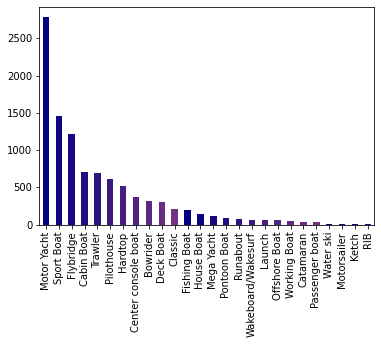

In [36]:
colors = [(x/22.0, x/50.0, 0.5) for x in range(len(data["Condition"].unique()))]

data["Boat Type"].value_counts().plot.bar(color = colors)

In [37]:
replace_type = {
    'Motor Yacht' : 0, #have a cabin that accommodate overnight use; likely to be at least 33 feet (10 m) in length
    'Motorsailer' : 0, #typically a yacht, that can derive power from its sails or engine
    'Sport Boat' : 1, #only for sport uses (races); no cabins etc.
    'Flybridge' : 2, #a large flat-bottomed coasting boat; fast boat
    'Cabin Boat' : 3, #has space for people to sleep or hide during bad weather
    'Fishing Boat' : 4,
    'Trawler' : 4, #kind of fishing boat
    'Pilothouse' : 5, #usually only with space for helmsman (sternik)
    'Center console boat' : 5, #single-decked open boat where the helm is in the center; there is a cabin on some models
    'Hardtop' : 6, #a low maintenance model for those that leave their boats in the water
    'Bowrider' : 7, #a recreational motorboat that has a pointed bow with a seating area in front of the helm
    'Deck Boat' : 8, #a boat with a lot of deck space
    'Offshore Boat' : 8, #more space on deck, more length, likely to have cabin or storage
    'Classic' : 9, #wooden, older than 25 years
    'House Boat' : 10, #floating house
    'Pontoon Boat' : 11, #a flat-bottomed boat, (z plywakami)
    'RIB' : 11, #~pontoon
    'Mega Yacht' : 12, #luxurious cruise ship
    'Passenger boat' : 12, #ex. cruise ship
    'Runabout' : 13, #light motorboat
    'Water ski' : 14, #A broad ski used for skiing on water while being towed by a motorboat
    'Wakeboard/Wakesurf' : 14, #a short board with foot bindings on which a rider is towed by a motorboat
    'Launch' : 15, #many different definitions
    'Ketch' : 15, #sailing boat with two masts (maszty)
    'Working Boat' : 16, #boat usually using for trade purposes
    'Catamaran' : 17 #two parallel hulls(kadlub) - the cause of shape of that boats 
    
}

data["Boat Type"] = data["Boat Type"].map(lambda x: replace_type.get(x))

In [38]:
index = np.arange(len(data["Condition"])) #przeindeksowanie zbioru w celu unikniecia bledow w dalszymm preprocessingu
data = data.reindex(index)

Kolumna Type również zawiera trochę śmieci jednak może zostać użyta do uzupełniania brakujących danych w kolumnach: Condition i Fuel Type.

In [40]:
data["Type"].unique()

array(['new boat from stock', 'Used boat', 'Used boat,Unleaded',
       'Used boat,Electric', ', ,Used boat',
       'new boat from stock,Unleaded', 'Used boat,Diesel', nan,
       'new boat on order', ', ,Used boat,Unleaded', 'Unleaded',
       'new boat on order,Unleaded', ', ,, ,Used boat,Unleaded',
       'new boat from stock,Gas', ', ,Used boat,Diesel', 'Diesel',
       'Display Model,Unleaded', 'Display Model', 'Used boat,Gas',
       ', ,Used boat,Electric', 'new boat from stock,Diesel',
       'new boat from stock,Electric', ', ,, ,Used boat', ', ',
       ', ,, ,Used boat,Diesel', 'new boat on order,Diesel',
       'new boat from stock,Hybrid', 'Display Model,Diesel',
       'Used boat,Hybrid', ', ,new boat from stock', 'Display Model,Gas',
       ', ,new boat on order,Unleaded', ', ,Display Model,Unleaded',
       'Display Model,Electric', ', ,, ,Used boat,Electric', 'Electric',
       'Used boat,Propane'], dtype=object)

In [41]:
data["Condition"] = data["Condition"].fillna('')
data["Type"] = data["Type"].fillna('')
data["Fuel Type"] = data["Fuel Type"].fillna('')

In [42]:
data["Condition"].value_counts()

                          6924
very good                 1125
new                        872
as new                     493
good                       391
well-groomed               202
used                       103
to be done up                9
needs a reconditioning       2
defect                       1
for tinkers                  1
Name: Condition, dtype: int64

In [43]:
def fillCon(string):
    for i in range(len(data["Condition"])):
        if data["Condition"].loc[i] == '':
            if ~(data["Type"].loc[i] == ''):
                temp = data["Type"].loc[i].split(',')
                for s in temp:
                    s = s.split(' ')[0].strip()
                    if s == string:
                        data["Condition"][i] = s
                        break
                        
fillCon('new')
fillCon('Used')
fillCon('Display')

C:\Users\Karolina\AppData\Local\Temp\ipykernel_3904\3898050784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Condition"][i] = s


<AxesSubplot:>

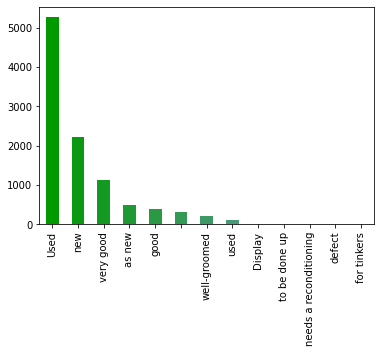

In [44]:
colors = [(x/25.0, 0.6, x/15.0) for x in range(len(data["Condition"]))]

data["Condition"].value_counts().plot.bar(color = colors)

In [45]:
data["Condition"].unique()

array(['as new', 'new', 'good', 'well-groomed', 'Used', 'very good',
       'used', '', 'to be done up', 'Display', 'defect',
       'needs a reconditioning', 'for tinkers'], dtype=object)

In [46]:
replace_cond = {
    'as new' : 0,
    'new' : 0,
    'good' : 1,
    'very good' : 1,
    'well-groomed' : 1,
    'Used' : 2,
    'used' : 2,
    'to be done up' : 3,
    'Display' : 3,
    'defect' : 3,
    'needs a reconditioning' : 3,
    'for tinkers' : 3,
    '' : 3
}

data["Condition"] = data["Condition"].map(lambda x: replace_cond.get(x))

In [48]:
def fillFuel(string):
    for i in range(len(data["Fuel Type"])):
        if data["Fuel Type"].loc[i] == '':
            if ~(data["Type"].loc[i] == ''):
                temp = data["Type"].loc[i].split(',')
                for s in temp:
                    s = s.split(' ')
                    for st in s:
                        if st == string:
                            data["Fuel Type"][i] = s
                            break
                            
                        
fillFuel('Electric')
fillFuel('Unleaded')
fillFuel('Gas')
fillFuel('Propane')
fillFuel('Diesel')
fillFuel('Hybrid')

<AxesSubplot:>

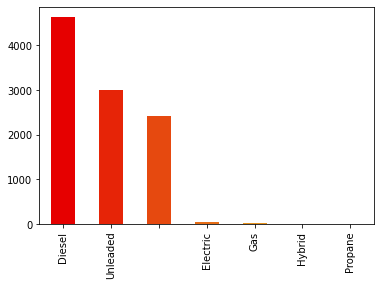

In [49]:
colors = [(0.9, x/7.0, x/35.0) for x in range(len(data["Fuel Type"]))]

data["Fuel Type"].value_counts().plot.bar(color = colors)

In [50]:
replace_fuel = {
    'Diesel' : 0,
    'Unleaded' : 1,
    '' : 2,
    'Electric' : 2,
    'Gas' : 2,
    'Hybrid' : 2,
    'Propane' : 2,
}

data["Fuel Type"] = data["Fuel Type"].map(lambda x: replace_fuel.get(x))

Kolumnę Equipment zamieniam na dane 0/1 nie zajmując się rodzajem ekwipunku.

In [52]:
data["Equipment"] = data["Equipment"].map(lambda x: 1 if x is not None else 0)
data["Equipment"] = pd.to_numeric(data["Equipment"])

Następnie zamieniam kolumny Material i Propulsion na dane numeryczne - analogicznie jak wcześniej.

<AxesSubplot:>

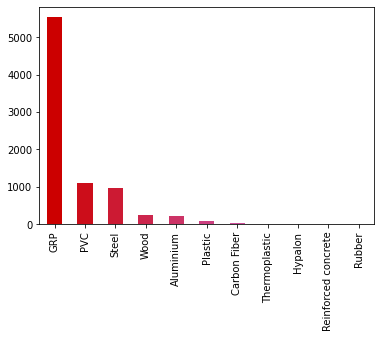

In [53]:
colors = [(0.8, x/20, x/10.0) for x in range(len(data["Material"].unique()))]

data["Material"].value_counts().plot.bar(color = colors)

In [54]:
data["Material"] = data["Material"].fillna('')
replace_material = {
    'GRP' : 0, 
    'PVC' : 1,
    'Steel' : 1,
    'Aluminium' : 2, 
    'Wood' : 2,
    'Plastic' : 3, 
    'Hypalon' : 3, 
    'Carbon Fiber' : 3, 
    'Reinforced concrete' : 3,
    'Thermoplastic' : 3, 
    'Rubber' : 3,
    '' : 4
}

data["Material"] = data["Material"].map(lambda x: replace_material.get(x))

<AxesSubplot:>

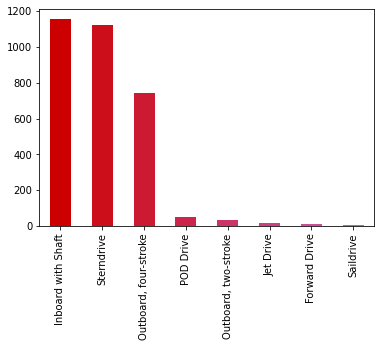

In [55]:
colors = [(0.8, x/20, x/10.0) for x in range(len(data["Propulsion"].unique()))]

data["Propulsion"].value_counts().plot.bar(color = colors)

In [56]:
data["Propulsion"] = data["Propulsion"].fillna('')
replace_material = {
    'Inboard with Shaft' : 0, 
    'Sterndrive' : 1,
    'Outboard, four-stroke' : 2, 
    'POD Drive' : 3,
    'Outboard, two-stroke' : 4, 
    'Jet Drive' : 5, 
    'Forward Drive' : 6,
    'Saildrive' : 6,
    '' : 6
}

data["Propulsion"] = data["Propulsion"].map(lambda x: replace_material.get(x))

Engine zawiera zbyt dużo różnych danych, więc jest tak samo użyteczna jak Manufacturer czy Model.

In [57]:
data = data.drop(["Engine"], axis = 1)

Dużo więcej informacji można wyciągnąć z kolumn Engine Performance i Engine Hours.

In [58]:
data["Engine Performance"] = data["Engine Performance"].fillna("1 x 0 HP")

data["Engine Performance"] = data["Engine Performance"].map(lambda x: x.split(' ')[2].strip())

data["Engine Performance"] = pd.to_numeric(data["Engine Performance"])
data["Engine Performance"] = data["Engine Performance"].map(lambda x: 0 if x < 100 else 1 if x < 300 else 
                                                           2 if x < 800 else 3 if x < 1200 else 4 if x < 2000 else 5)

In [59]:
data["Engine Hours"] = data["Engine Hours"].fillna("0")

data["Engine Hours"] = data["Engine Hours"].map(lambda x: x.split(' ')[0].strip())

data["Engine Hours"] = pd.to_numeric(data["Engine Hours"])
data["Engine Hours"] = data["Engine Hours"].map(lambda x: 0 if x == 0 else 1 if x < 100 else 2 if x < 350 else 
                                                3 if x < 800 else 4 if x < 1200 else 5 if x < 5000 else 6)

Skaluję dane z kolumny Number of views last 7 days zakładając, że im więcej wyświetleń tym lepsza cena łodzi.

In [60]:
data["Number of views last 7 days"] = data["Number of views last 7 days"].fillna("0")
data["Number of views last 7 days"] = data["Number of views last 7 days"].map(lambda x: ''.join(x.split("'")).strip())

data["Number of views last 7 days"] = pd.to_numeric(data["Number of views last 7 days"])
data["Number of views last 7 days"] = data["Number of views last 7 days"].map(lambda x: 0 if x == 0 else 1 if x < 900 else 2)

Zamiana danych z pozostałych kolmnu typu object na dane numeryczne.

In [61]:
data["Length"] = data["Length"].fillna("0")
data["Length"] = data["Length"].map(lambda x: x.split(' ')[0].strip())
data["Length"] = pd.to_numeric(data["Length"])
data["Length"] = data["Length"].map(lambda x: x if x != 0 else None)

data["Width"] = data["Width"].fillna("0")
data["Width"] = data["Width"].map(lambda x: x.split(' ')[0].strip())
data["Width"] = pd.to_numeric(data["Width"])
data["Width"] = data["Width"].map(lambda x: x if x != 0 else None)

data["Depth"] = data["Depth"].fillna("0")
data["Depth"] = data["Depth"].map(lambda x: x.split(' ')[0].strip())
data["Depth"] = pd.to_numeric(data["Depth"])
data["Depth"] = data["Depth"].map(lambda x: x if x != 0 else None)

data["Displacement"] = data["Displacement"].fillna("0")
data["Displacement"] = data["Displacement"].map(lambda x: x.split(' ')[0].strip())
data["Displacement"] = data["Displacement"].map(lambda x: ''.join(x.split("'")).strip())
data["Displacement"] = pd.to_numeric(data["Displacement"])
data["Displacement"] = data["Displacement"].map(lambda x: x if x != 0 else None)

data["Fresh Water Cap"] = data["Fresh Water Cap"].fillna("0")
data["Fresh Water Cap"] = data["Fresh Water Cap"].map(lambda x: x.split(' ')[0].strip())
data["Fresh Water Cap"] = pd.to_numeric(data["Fresh Water Cap"])
data["Fresh Water Cap"] = data["Fresh Water Cap"].map(lambda x: 0 if x < 100 else 1 if x < 1000 else 2)

data["Holding Tank"] = data["Holding Tank"].fillna("0")
data["Holding Tank"] = data["Holding Tank"].map(lambda x: x.split(' ')[0].strip())
data["Holding Tank"] = pd.to_numeric(data["Holding Tank"])
data["Fresh Water Cap"] = data["Fresh Water Cap"].map(lambda x: 0 if x < 100 else 1 if x < 1000 else 2)

data["Fuel Capacity"] = data["Fuel Capacity"].fillna("0")
data["Fuel Capacity"] = data["Fuel Capacity"].map(lambda x: x.split(' ')[0].strip())
data["Fuel Capacity"] = pd.to_numeric(data["Fuel Capacity"])
data["Fuel Capacity"] = data["Fuel Capacity"].map(lambda x: x if x != 0 else None)

Usuwam dla pewności wartości Nan.

In [62]:
data = data.dropna(subset = ["Boat Type"])

Rozdzielenie danych.

In [63]:
y = data["Price"]
y

0         3337.0
1         3490.0
2         3770.0
3         3885.0
4         3150.0
          ...   
10118    12000.0
10119    12000.0
10120    12000.0
10121    11800.0
10122    11442.5
Name: Price, Length: 9902, dtype: float64

In [64]:
data = data.drop(["Currency", "Price", "Type"], axis = 1) 

Podział na train i test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=7)

Funkcje do uzupełniania pustych wierszy medianą danych dla grupy łodzi tego samego typu.

In [66]:
def train_med(column, medians):
    for bt in X_train["Boat Type"].unique():
        if ~(np.isnan(bt)):
            medians[bt] = column[(~column.isna()) & (X_train["Boat Type"] == bt)].median()
            
def test_med(column, medians):
    for bt in X_test["Boat Type"].unique():
        if ~(np.isnan(bt)):
            medians[bt] = column[(~column.isna()) & (X_test["Boat Type"] == bt)].median()
            
def fill_med_train(column, medians):
    for index, row in X_train.iterrows():
        if ~(np.isnan(row["Boat Type"])):
            if np.isnan(row[column]):
                if row["Boat Type"] in medians.values():
                    X_train.loc[index, column] = medians[row["Boat Type"]]
                else:
                    X_train.loc[index, column] = 0
                    
def fill_med_test(column, medians):
    for index, row in X_test.iterrows():
        if ~(np.isnan(row["Boat Type"])):
            if np.isnan(row[column]):
                if row["Boat Type"] in medians2.values():
                    X_test.loc[index, column] = medians[row["Boat Type"]]
                else:
                    X_test.loc[index, column] = 0

In [110]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Year Built"], medians1)
test_med(X_test["Year Built"], medians2)

fill_med_train("Year Built", medians1)
fill_med_test("Year Built", medians2)

X_train["Year Built"] = X_train["Year Built"].fillna(0)
X_test["Year Built"] = X_test["Year Built"].fillna(0)

In [68]:
X_train["Year Built"] = X_train["Year Built"].map(lambda x: 0 if x > 2010 else 1 if x > 1990 else 2 if x > 1970 else 3)
X_test["Year Built"] = X_test["Year Built"].map(lambda x: 0 if x > 2010 else 1 if x > 1990 else 2 if x > 1970 else 3)

In [69]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Length"], medians1)
test_med(X_test["Length"], medians2)

fill_med_train("Length", medians1)
fill_med_test("Length", medians2)

X_train["Length"] = X_train["Length"].fillna(0)
X_test["Length"] = X_test["Length"].fillna(0)

In [70]:
X_train["Length"] = X_train["Length"].map(lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 15 else 3 if x < 40 else 4)
X_test["Length"] = X_test["Length"].map(lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 15 else 3 if x < 40 else 4)

In [71]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Width"], medians1)
test_med(X_test["Width"], medians2)

fill_med_train("Width", medians1)
fill_med_test("Width", medians2)

X_train["Width"] = X_train["Width"].fillna(0)
X_test["Width"] = X_test["Width"].fillna(0)

In [72]:
X_train["Width"] = X_train["Width"].map(lambda x: 0 if x == 0 else 1 if x < 4 else 2 if x < 8 else 3 if x < 15 else 4)
X_test["Width"] = X_test["Width"].map(lambda x: 0 if x == 0 else 1 if x < 4 else 2 if x < 8 else 3 if x < 15 else 4)

In [73]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Depth"], medians1)
test_med(X_test["Depth"], medians2)

fill_med_train("Depth", medians1)
fill_med_test("Depth", medians2)

X_train["Depth"] = X_train["Depth"].fillna(0)
X_test["Depth"] = X_test["Depth"].fillna(0)

In [74]:
X_train["Depth"] = X_train["Depth"].map(lambda x: 0 if x == 0 else 1 if x < 4 else 2 if x < 10 else 3 if x < 30 else 4)
X_test["Depth"] = X_test["Depth"].map(lambda x: 0 if x == 0 else 1 if x < 4 else 2 if x < 10 else 3 if x < 30 else 4)

In [75]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Displacement"], medians1)
test_med(X_test["Displacement"], medians2)

fill_med_train("Displacement", medians1)
fill_med_test("Displacement", medians2)

X_train["Displacement"] = X_train["Displacement"].fillna(0)
X_test["Displacement"] = X_test["Displacement"].fillna(0)

In [76]:
X_train["Displacement"] = X_train["Displacement"].map(lambda x: 0 if x == 0 else 1 if x < 400 else 2 if x < 1000 else 3 if x < 3000 else 4)
X_test["Displacement"] = X_test["Displacement"].map(lambda x: 0 if x == 0 else 1 if x < 400 else 2 if x < 1000 else 3 if x < 3000 else 4)

In [77]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Fuel Capacity"], medians1)
test_med(X_test["Fuel Capacity"], medians2)

fill_med_train("Fuel Capacity", medians1)
fill_med_test("Fuel Capacity", medians2)

X_train["Fuel Capacity"] = X_train["Fuel Capacity"].fillna(0)
X_test["Fuel Capacity"] = X_test["Fuel Capacity"].fillna(0)

In [78]:
X_train["Fuel Capacity"] = X_train["Fuel Capacity"].map(lambda x: 0 if x == 0 else 1 if x < 200 else 2 if x < 1000 else 3 if x < 5000 else 4)
X_test["Fuel Capacity"] = X_test["Fuel Capacity"].map(lambda x: 0 if x == 0 else 1 if x < 200 else 2 if x < 1000 else 3 if x < 5000 else 4)

<AxesSubplot:>

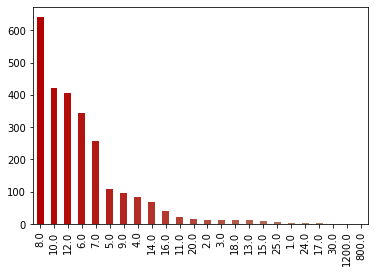

In [79]:
colors = [(0.7, x/40.0, x/50.0) for x in range(len(X_train["Cert Number of People"].unique()))]

X_train["Cert Number of People"].value_counts().plot.bar(color = colors)

In [80]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Cert Number of People"], medians1)
test_med(X_test["Cert Number of People"], medians2)

fill_med_train("Cert Number of People", medians1)
fill_med_test("Cert Number of People", medians2)

X_train["Cert Number of People"] = X_train["Cert Number of People"].fillna(0)
X_test["Cert Number of People"] = X_test["Cert Number of People"].fillna(0)

In [81]:
X_train["Cert Number of People"] = X_train["Cert Number of People"].map(lambda x: 0 if x < 2 else 1 if x < 6 else 
                                                                        2 if x < 24 else 3)
X_test["Cert Number of People"] = X_test["Cert Number of People"].map(lambda x: 0 if x < 2 else 1 if x < 6 else 
                                                                      2 if x < 24 else 3)

<AxesSubplot:>

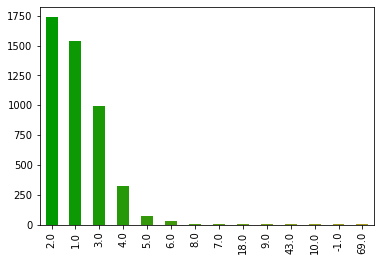

In [82]:
colors = [(x/20.0, 0.6, x/100.0) for x in range(len(X_train["Number of Cabins"].unique()))]

X_train["Number of Cabins"].value_counts().plot.bar(color = colors)

In [83]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Number of Cabins"], medians1)
test_med(X_test["Number of Cabins"], medians2)

fill_med_train("Number of Cabins", medians1)
fill_med_test("Number of Cabins", medians2)

X_train["Number of Cabins"] = X_train["Number of Cabins"].map(lambda x: 0 if x <= 0 else x)
X_test["Number of Cabins"] = X_test["Number of Cabins"].map(lambda x: 0 if x <= 0 else x)

X_train["Number of Cabins"] = X_train["Number of Cabins"].fillna(0)
X_test["Number of Cabins"] = X_test["Number of Cabins"].fillna(0)

In [84]:
X_train["Number of Cabins"] = X_train["Number of Cabins"].map(lambda x: 0 if x == 0 else 1 if x < 3 else 
                                                                        2 if x < 6  else 3)
X_test["Number of Cabins"] = X_test["Number of Cabins"].map(lambda x: 0 if x == 0 else 1 if x < 3 else 
                                                                      2 if x < 6 else 3)

<AxesSubplot:>

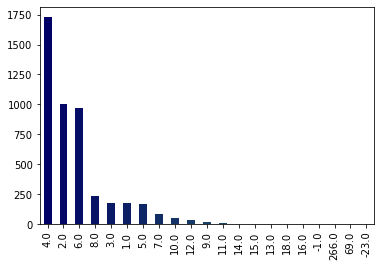

In [85]:
colors = [(x/100.0, x/40.0, 0.4) for x in range(len(X_train["Number of beds"].unique()))]

X_train["Number of beds"].value_counts().plot.bar(color = colors)

In [86]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Number of beds"], medians1)
test_med(X_test["Number of beds"], medians2)

fill_med_train("Number of beds", medians1)
fill_med_test("Number of beds", medians2)

X_train["Number of beds"] = X_train["Number of beds"].fillna(0)
X_test["Number of beds"] = X_test["Number of beds"].fillna(0)

In [87]:
X_train["Number of beds"] = X_train["Number of beds"].map(lambda x: 0 if x <= 0 else 1 if x < 4 else 
                                                                        2 if x < 10  else 3)
X_test["Number of beds"] = X_test["Number of beds"].map(lambda x: 0 if x <= 0 else 1 if x < 4 else 
                                                                      2 if x < 11 else 3)

<AxesSubplot:>

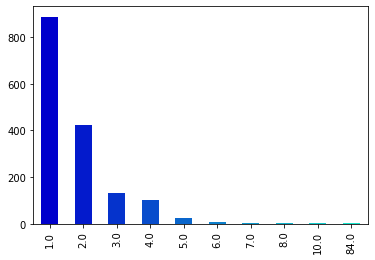

In [88]:
colors = [(x/100.0, x/10.0, 0.8) for x in range(len(X_train["Number of Toilets"].unique()))]

X_train["Number of Toilets"].value_counts().plot.bar(color = colors)

In [89]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Number of Toilets"], medians1)
test_med(X_test["Number of Toilets"], medians2)

fill_med_train("Number of Toilets", medians1)
fill_med_test("Number of Toilets", medians2)

X_train["Number of Toilets"] = X_train["Number of Toilets"].fillna(0)
X_test["Number of Toilets"] = X_test["Number of Toilets"].fillna(0)

In [90]:
X_train["Number of Toilets"] = X_train["Number of Toilets"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 
                                                                        2 if x < 4  else 3)
X_test["Number of Toilets"] = X_test["Number of Toilets"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 
                                                                      2 if x < 4 else 3)

<AxesSubplot:>

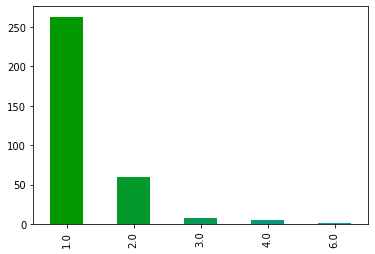

In [91]:
colors = [(x/100.0, 0.6, x/6.0) for x in range(len(X_train["Number of Bathrooms"].unique()))]

X_train["Number of Bathrooms"].value_counts().plot.bar(color = colors)

In [92]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Number of Bathrooms"], medians1)
test_med(X_test["Number of Bathrooms"], medians2)

fill_med_train("Number of Bathrooms", medians1)
fill_med_test("Number of Bathrooms", medians2)

X_train["Number of Bathrooms"] = X_train["Number of Bathrooms"].fillna(0)
X_test["Number of Bathrooms"] = X_test["Number of Bathrooms"].fillna(0)

In [93]:
X_train["Number of Bathrooms"] = X_train["Number of Bathrooms"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 2)
X_test["Number of Bathrooms"] = X_test["Number of Bathrooms"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 2)

<AxesSubplot:>

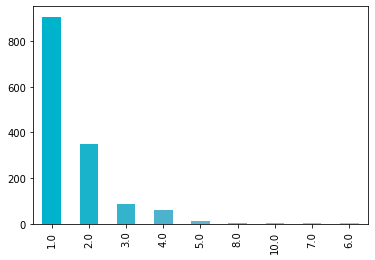

In [94]:
colors = [(x/10.0, 0.7, 0.8) for x in range(len(X_train["Number of Showers"]))]

X_train["Number of Showers"].value_counts().plot.bar(color = colors)

In [95]:
medians1 = dict()
medians2 = dict()

train_med(X_train["Number of Showers"], medians1)
test_med(X_test["Number of Showers"], medians2)

fill_med_train("Number of Showers", medians1)
fill_med_test("Number of Showers", medians2)

In [96]:
X_train["Number of Showers"] = X_train["Number of Showers"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 2 if x < 4 else 3)
X_test["Number of Showers"] = X_test["Number of Showers"].map(lambda x: 0 if x <= 0 else 1 if x < 2 else 2 if x < 4 else 3)

In [97]:
#X_train["Boat Type"] = X_train["Boat Type"].fillna(17)
#X_test["Boat Type"] = X_test["Boat Type"].fillna(17)

X_train["Boat Type"] = X_train["Boat Type"].astype('int')
X_test["Boat Type"] = X_test["Boat Type"].astype('int')

In [98]:
#y_train = y_train.fillna(0)
#y_test = y_train.fillna(0)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [99]:
X_train = X_train[:3000]
y_train = y_train[:3000]

X_test = X_test[:1500]
y_test = y_test[:1500]

In [100]:
ss = StandardScaler()
X_train_ = ss.fit_transform(X_train)
X_test_ = ss.transform(X_test)

In [101]:
#LinearSVR
pipe1 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVR(max_iter = 10000))])

param_grid1 = {'preprocessing': [StandardScaler(), None], 'classifier__C': [0.01, 0.1, 1, 10]}

grid_1 = GridSearchCV(pipe1, param_grid1, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 10, 'preprocessing': None}

In [119]:
#SVR
pipe2 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVR(kernel = 'rbf'))])

param_grid2 = {'preprocessing': [StandardScaler(), None], 'classifier__C': [0.01, 0.1, 1]}

grid_2 = GridSearchCV(pipe2, param_grid2, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 1, 'preprocessing': StandardScaler()}

In [121]:
#RandomForestRegressor
param_grid4 = {'n_estimators' : [100, 110, 120, 140]}

grid_4 = GridSearchCV(RandomForestRegressor(), param_grid4, return_train_score=True)

grid_4.fit(X_train_, y_train)
grid_4.best_params_

{'n_estimators': 140}

In [122]:
#BaggingRegressor
param_grid5 = {'n_estimators' : [15, 20, 30, 40]}

grid_5 = GridSearchCV(BaggingRegressor(), param_grid5, return_train_score=True)

grid_5.fit(X_train_, y_train)
grid_5.best_params_

{'n_estimators': 30}

In [123]:
#KNeighborsRegressor
param_grid6 = {'n_neighbors': [3, 5, 6, 7, 9]}

grid_6 = GridSearchCV(KNeighborsRegressor(), param_grid6, return_train_score=True)

grid_6.fit(X_train_, y_train)
grid_6.best_params_

{'n_neighbors': 3}

In [124]:
#ExtraTreesRegressor
param_grid7 = {'n_estimators' : [100, 120, 130, 140]}

grid_7 = GridSearchCV(ExtraTreesRegressor(), param_grid7, return_train_score=True)

grid_7.fit(X_train_, y_train)
grid_7.best_params_

{'n_estimators': 100}

In [125]:
#GradientBoostingRegressor
param_grid8 = {'n_estimators' : [100, 130, 140, 150], 'learning_rate'  : [0.1, 0.5, 1.0]}

grid_8 = GridSearchCV(GradientBoostingRegressor(), param_grid8, return_train_score=True)

grid_8.fit(X_train_, y_train)
grid_8.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [137]:
from sklearn import  metrics


models = []
models.append(('SVR linear', grid_1.best_estimator_))
models.append(('SVR rbf', grid_2.best_estimator_))
models.append(('Random Forest Regressor', grid_4.best_estimator_))
models.append(('Bagging Regressor', grid_5.best_estimator_))
models.append(('KNeighbors Regressor', grid_6.best_estimator_))
models.append(('Extra Trees Regressor', grid_7.best_estimator_))
models.append(('Gradient Boosting Regressor', grid_8.best_estimator_))


r2 = []
mse = []
evs = []
for name, model in models:
    print(name)
    if name in ["SVR linear", "SVR rbf"]:
        y_pred = model.predict(X_test)
        # jak dobrze model regresji wyjaśnia zaobserwowane dane
        print("score: {}".format(r2_score(y_test, y_pred)))
        r2.append(r2_score(y_test, y_pred))
        # srednia z kwadratu miedzy aktualna a przewidziana wartoscia dla wszystkich danych
        print("mean squared score: {}".format(mean_squared_error(y_test, y_pred)))
        mse.append(mean_squared_error(y_test, y_pred))
        # jest wskaźnikiem, który w formie proporcji wskazuje, na ile zmienność danych wyjaśnia dany model (jak najblizej 1)
        print("explained variance score: {}".format(explained_variance_score(y_test, y_pred)))
        evs.append(explained_variance_score(y_test, y_pred))
        print()
    else:
        y_pred = model.predict(X_test_)
        # jak dobrze model regresji wyjaśnia zaobserwowane dane
        print("score: {}".format(r2_score(y_test, y_pred)))
        r2.append(r2_score(y_test, y_pred))
        # srednia z kwadratu miedzy aktualna a przewidziana wartoscia dla wszystkich danych
        print("mean squared score: {}".format(mean_squared_error(y_test, y_pred)))
        mse.append(mean_squared_error(y_test, y_pred))
        # jest wskaźnikiem, który w formie proporcji wskazuje, na ile zmienność danych wyjaśnia dany model (jak najblizej 1)
        print("explained variance score: {}".format(explained_variance_score(y_test, y_pred)))
        evs.append(explained_variance_score(y_test, y_pred))
        print()

SVR linear
score: -0.013621352132082709
mean squared score: 634132267722.735
explained variance score: 0.04965770950648141

SVR rbf
score: -0.07150914126637042
mean squared score: 670347482526.5348
explained variance score: 8.420302887279796e-05

Random Forest Regressor
score: 0.5632738622110208
mean squared score: 273220503442.8175
explained variance score: 0.5671927386195408

Bagging Regressor
score: 0.5500544171749535
mean squared score: 281490728454.4795
explained variance score: 0.554034286020519

KNeighbors Regressor
score: 0.5941485510830775
mean squared score: 253904970646.97726
explained variance score: 0.5960839650137477

Extra Trees Regressor
score: 0.527501022286381
mean squared score: 295600371483.8552
explained variance score: 0.5304182907041204

Gradient Boosting Regressor
score: 0.6352590278235579
mean squared score: 228185820406.33926
explained variance score: 0.6367138570189609



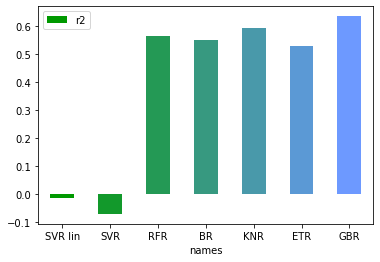

In [146]:
d1 = pd.DataFrame({"names" : ["SVR lin", "SVR", "RFR", "BR", "KNR", "ETR", "GBR"], "r2" : r2})

colors = [(x/14.0, 0.6, x/6.0) for x in range(7)]

ax = d1.plot.bar(x = 'names', y = 'r2', rot = 0, color = colors)

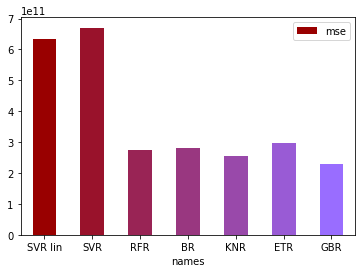

In [147]:
d2 = pd.DataFrame({"names" : ["SVR lin", "SVR", "RFR", "BR", "KNR", "ETR", "GBR"], "mse" : mse})

colors = [(0.6, x/14.0, x/6.0) for x in range(7)]

ax = d2.plot.bar(x = 'names', y = 'mse', rot = 0, color = colors)

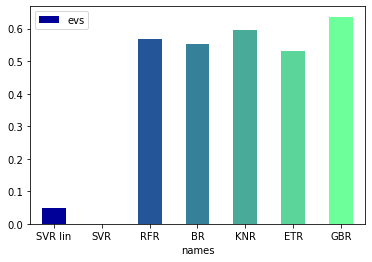

In [148]:
d3 = pd.DataFrame({"names" : ["SVR lin", "SVR", "RFR", "BR", "KNR", "ETR", "GBR"], "evs" : evs})

colors = [(x/14.0, x/6.0, 0.6) for x in range(7)]

ax = d3.plot.bar(x = 'names', y = 'evs', rot = 0, color = colors)

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

history = History()

model = Sequential()
model.add(Dense(units=5, input_shape=X_train.shape[1:], kernel_initializer='normal', activation='relu'))
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='normal')) 

model.compile(loss = "mean_squared_error", optimizer = keras.optimizers.SGD(learning_rate = 1e-1))
history = model.fit(X_train_scaled, y_train, epochs=100)

y_pred = model.predict(X_test_scaled)

Epoch 1/100
94/94 [==============================] - 2s 6ms/step - loss: 1085278715904.0000
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 1106352406528.0000
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 1090154659840.0000
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 1109715320832.0000
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 1098806198272.0000
Epoch 6/100
94/94 [==============================] - 1s 11ms/step - loss: 1082892222464.0000
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 1098941267968.0000
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1073141186560.0000
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 1103152545792.0000
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 1097613508608.0000
Epoch 11/100
94/94 [==============================] - 0s 3ms/step - loss: 1085

94/94 [==============================] - 0s 3ms/step - loss: 1095174127616.0000
Epoch 90/100
94/94 [==============================] - 0s 3ms/step - loss: 1104850321408.0000
Epoch 91/100
94/94 [==============================] - 0s 3ms/step - loss: 1076984283136.0000
Epoch 92/100
94/94 [==============================] - 0s 3ms/step - loss: 1092269768704.0000
Epoch 93/100
94/94 [==============================] - 0s 2ms/step - loss: 1091116400640.0000
Epoch 94/100
94/94 [==============================] - 0s 3ms/step - loss: 1080161337344.0000
Epoch 95/100
94/94 [==============================] - 0s 2ms/step - loss: 1075776389120.0000
Epoch 96/100
94/94 [==============================] - 0s 2ms/step - loss: 1072778969088.0000
Epoch 97/100
94/94 [==============================] - 0s 3ms/step - loss: 1071389671424.0000
Epoch 98/100
94/94 [==============================] - 0s 3ms/step - loss: 1090794618880.0000
Epoch 99/100
94/94 [==============================] - 0s 3ms/step - loss: 111060962

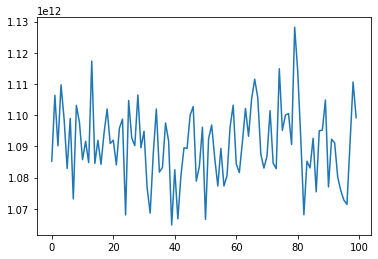

In [134]:
plt.plot(pd.DataFrame(history.history))
plt.show()

In [135]:
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print("Mean squared error =", round(mse, 2))
print("Explained variance score =", round(evs, 2))

Mean squared error = 644586385576.68
Explained variance score = 0.0
